In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7
3.7.1 (v3.7.1:260ec2c36a, Oct 20 2018, 03:13:28) 
[Clang 6.0 (clang-600.0.57)]
sys.version_info(major=3, minor=7, micro=1, releaselevel='final', serial=0)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import os
# import codecs

In [3]:
target_url = ("/Users/devkrroy/Dev/Projects/snow/data/export3.xlsx")
# target_url = ("C:/Dev/Projects/snow/data/export3.xlsx")

In [4]:
df = pd.read_excel(target_url)

In [5]:
df.info()
# print(df.columns.values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95373 entries, 0 to 95372
Data columns (total 28 columns):
Number                95373 non-null object
Assignment_group      95373 non-null object
Priority              95373 non-null object
State                 95373 non-null object
Category              93947 non-null object
Subcategory           61328 non-null object
Severity              95373 non-null object
Closure_CI            94492 non-null object
Location              95079 non-null object
Close_code            94559 non-null object
Configuration_item    95373 non-null object
Child_Incidents       95373 non-null int64
Contact_type          95373 non-null object
Duration              95373 non-null int64
Impact                95373 non-null object
Short_description     95373 non-null object
Created               95373 non-null datetime64[ns]
dates                 95373 non-null datetime64[ns]
date                  95373 non-null datetime64[ns]
day                   95373 non-n

In [6]:
df.head()

,Number,Assignment_group,Priority,State,Category,Subcategory,Severity,Closure_CI,Location,Close_code,...,date,day,month,dom,week,week2,cluster,cluster1,cluster_name1,cluster_name
0,INC0406604,DHE-Command Center,4 - Low,Closed,Server,Windows,3 - Low,phx-vapp-689,Corporate Office - Phoenix 1,Resolved by Event,...,2018-09-01,Saturday,September,1,1,1,1,16,volume space,threshold set disk
1,INC0406605,DH-Enterprise IT Service Cntr,4 - Low,Closed,Security,NaN,3 - Low,Network Account Lock,St Mary's Medical Center San Francisco (SMMC-SF),Account Unlock,...,2018-09-01,Saturday,September,1,1,1,48,47,login,login
2,INC0406606,DHE-RCM-AppOp-Applications,3 - Moderate,Closed,Application,Revenue Cycle,3 - Low,Soarian DM,Corporate Office - Phoenix 1,Resolved by Event,...,2018-09-01,Saturday,September,1,1,1,44,7,login,cerner
3,INC0406607,DH-Enterprise IT Service Cntr,4 - Low,Closed,Security,NaN,3 - Low,Network Account Issue,Bruceville Terrace,Password Reset,...,2018-09-01,Saturday,September,1,1,1,4,4,login,login
4,INC0406608,DH-Enterprise IT Service Cntr,4 - Low,Closed,Application,Clinical,3 - Low,Clairvia,St Mary's Medical Center San Francisco (SMMC-SF),Password Reset,...,2018-09-01,Saturday,September,1,1,1,18,36,login,login


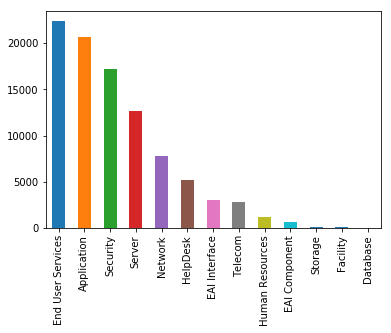

In [7]:
# plot few charts to understand the data

# Category by count - this should help understand "Number of Clusters" we should have

top_categories_df = df['Category'].value_counts()[:20]
top_categories_df.plot.bar(x = 'Category', y = 'Counts')

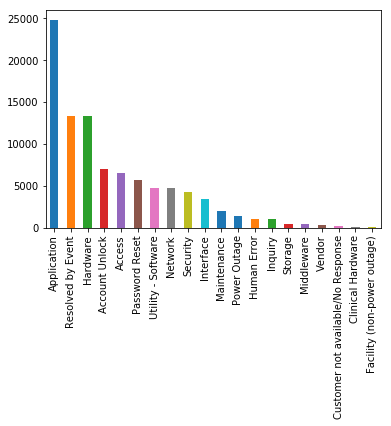

In [8]:
# Close_code by count 

top_close_code_df = df['Close_code'].value_counts()[:20]
top_close_code_df.plot.bar(x = 'Close_code', y = 'Counts')

In [9]:
# based on the 2 charts above we will go with 30 - 50 clusters of data

In [10]:
# identify the cols needed
cols = ['Number', 'Created', 'Assignment_group', 'Priority', 'State', 'Category',
       'Subcategory', 'Severity', 'Closure_CI', 'Location', 'Close_code',
       'Configuration_item', 'Child_Incidents', 'Contact_type',
       'Duration', 'Impact', 'Short_description']
df = df[cols]

In [11]:
# copy the dataframe to a new dataframe before any row deletes
test = df.copy()
test = test.sort_values('Created')

In [12]:
# check for duplicate data
# test[test['Short_description'].duplicated(keep = 'first')].sort_values('Short_description').head(5)

In [13]:
# remove duplicates, we will still retain 1 row for analysis
# test = test.drop_duplicates('Short_description', keep = 'first')
print('Shape of the modified dataframe ', test.shape)

Shape of the modified dataframe  (95373, 17)


In [14]:
#Filter out some categories with instances < 50 for now , remove this filter in future
# test = incs.groupby("Category").filter(lambda x: len(x) > 50)
# test = incs.reset_index(drop = True)
test.Category.value_counts()

End User Services    22410
Application          20651
Security             17171
Server               12687
Network               7831
HelpDesk              5169
EAI Interface         3028
Telecom               2832
Human Resources       1224
EAI Component          697
Storage                140
Facility               100
Database                 7
Name: Category, dtype: int64

In [15]:
pd.options.display.max_colwidth = 100

In [16]:
# remove any accent from letters
def unidecode_text(text):
    try:
        text = unidecode.unidecode(text)
    except:
        pass
    return text

for col in ['Location', 'Short_description']:
    test[col] = test.apply(lambda row: unidecode_text(row[col]), axis = 1)

In [17]:
# copy location to another data frame and remove duplicates
locations = test['Location']
locations = locations.drop_duplicates(keep = 'first')
locations.head()

0                        Corporate Office - Phoenix 1
1    St Mary's Medical Center San Francisco (SMMC-SF)
3                                  Bruceville Terrace
5               Marian Regional Medical Center (MRMC)
7                    Woodland Memorial Hospital (WMH)
Name: Location, dtype: object

In [18]:
# stop words for location

# nltk text preprocessing
import string
import re
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import contractions

stop = stopwords.words('english')
lemmer = WordNetLemmatizer()

# add punctuations to the stop words
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop.extend(punc)

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def get_locations(text):

    # lower case
    text = text.lower()
#     text = text.str.lower()

    # replace '\', '/', '|', '-' with spaces, thes are usually entered to separate words
    # word tokenize doesn't tokenize on these
    text = re.sub(r'[.=\\/\|-]',' ', text)

    # replace contractions
    text = ' '.join(contractions.fix(word) for word in text.split())
#     text = text.apply(lambda x: ' '.join(contractions.fix(word) for word in x.split()))
    
    # tokenize text and remove puncutation, strip would remove from word begining or end
    text = [word.strip(string.punctuation) for word in word_tokenize(text)]
#     text = text.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in word_tokenize(x)))
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
#     text = text.apply(lambda x: ' '.join(word for word in word_tokenize(x) if not any(c.isdigit() for c in word)))

    # remove small tokens
    text = [word for word in text if len(word) > 1]
#     text = text.apply(lambda x: ' '.join(word for word in word_tokenize(x) if len(word) > 1))
    
    # remove stop words
    text = [word for word in text if word not in set(stop)]
#     text = text.apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in set(stop)))
    
    # pos tag text
    pos_tags = pos_tag(text)
    
    # lemmatize text
    text = [lemmer.lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
#     text = text.apply(lambda x: ' '.join(lemmer.lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tag(x)))
    
    text = ' '.join(text)
    
    return(text)
    
# locations_cleaned = get_locations(locations.astype(str))
locations_cleaned = locations.apply(lambda x: get_locations(str(x)))

In [19]:
locations_cleaned.head()

0                        corporate office phoenix
1    st mary medical center san francisco smmc sf
3                              bruceville terrace
5             marian regional medical center mrmc
7                  woodland memorial hospital wmh
Name: Location, dtype: object

In [20]:
# use the countvectorizer to convert to a list of words
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit_transform(locations_cleaned.values)

stop_locations = vectorizer.get_feature_names()
len(stop_locations)

525

In [21]:
stop_locations[100:110]

['crmc',
 'cruz',
 'data',
 'davis',
 'de',
 'deactivate',
 'department',
 'detention',
 'development',
 'dhmf']

In [22]:
# extend stop words
# words like issue, problem, resolve, fix - do not add more sense to the description and are common
new_stopwords = ['chw','edu','phx','vapp', 'issue', 'issues', 'problem', 'problems', 
                 'resolve', 'resolved', 'fix', 'fixed']

stop.extend(new_stopwords)

# add the locations to the stop words
stop.extend(stop_locations)


def pre_process(text):

    # lower case
    text = text.lower()

    # replace '\', '/', '|', '-' with spaces, thes are usually entered to separate words
    # word tokenize doesn't tokenize on these
    text = re.sub(r'[.=\\/\|-]',' ', text)

    # replace contractions
    text = ' '.join([contractions.fix(word) for word in text.split()])

    # "'d": changes to " would", 'disk changes to wouldisk - unwanted contraction
    # replace wouldisk with disk
    text = text.replace('wouldisk', 'disk')  # replace with disk    

    # 'not able' is a common way to report issue, replace 'not able' with 'unable'
    # also not gets removed as part of stop words
    text = text.replace('not able', 'unable')
    text = text.replace('user id', 'user')
    text = text.replace('username', 'user')
    
    # replace ms4 to medseries
    text = text.replace('ms4', 'medseries')
    
    # there are lot of places in the description where II (2 caps I) has been used as separator
    # this gets converted to small letter (ii) with high occurance, drop these letters
    text = text.replace(' ii ', ' ')  # replace with spaces
        
    # tokenize text and remove puncutation, strip would remove from word begining or end
    text = [word.strip(string.punctuation) for word in word_tokenize(text)]
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]

    # remove small tokens
    text = [word for word in text if len(word) > 2]
    
    # remove stop words
    text = [word for word in text if word not in set(stop)]
    
    # pos tag text
    pos_tags = pos_tag(text)
    
    # lemmatize text
    text = [lemmer.lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # some verbs probably get tagged as noun and are not lemmatized
    text = [lemmer.lemmatize(word, pos = 'v') for word in text]
    
    text = ' '.join(text)    
  
    return (text)
    
# cleaned_short_desc = pre_process(incs['Short_description'].astype(str))
%time cleaned_short_desc = test['Short_description'].apply(lambda x: pre_process(x))

CPU times: user 1min 34s, sys: 1.74 s, total: 1min 36s
Wall time: 1min 36s


In [23]:
cleaned_short_desc[0:20]

0                                   utilization threshold set disk file percent full
1                                                     account lock unable login user
2                                                                                   
3                                                                     password reset
4                              clairvia unable login password reset hduv do jmoyrong
5                                             account lock unable login user jyongco
6                              error message appear open cash_adjs clpdayend qrgxmsg
7                                            wow display leave monitor upside device
8                                          cpu utilization threshold set utilization
9                                                receive cash_adjs clpdayend qclxerr
10                                         cpu utilization threshold set utilization
11                                         cpu utilization thresh

In [24]:
# count of cells with no terms
print(cleaned_short_desc.apply(lambda x: x == '').sum())

138


In [25]:
def get_ips(text):
    
    # lower case
    text = text.str.lower()
    
    # capture the IPs    
    ip_pattern = re.compile(r'((-?)([A-Za-z0-9]{1,}[-.]{1,1}){2,6}([A-Za-z0-9]*))')  
    ip = text.apply(lambda x: ' '.join(word for word in re.split('[\': (),]', x) if ip_pattern.match(word)))
    
    return ip

ips = get_ips(test['Short_description'])

In [26]:
ips[0:20]

0                phx-vapp-689.chw.edu
1                                    
2                        phx-vapp-408
3                                    
4                                    
5                                    
6                                    
7                       10.203.212.24
8                phx-vapp-842.chw.edu
9                                    
10               phx-vapp-237.chw.edu
11               phx-vapp-238.chw.edu
12                      -10.248.84.17
13    chw-as1-2central-dsc 10.1.5.100
14     chw-as2-2central-dsc 10.1.5.10
15                phx-app-040.chw.edu
16                phx-app-034.chw.edu
17                                   
18                    phxdc23c-nas-07
19         chw-as1-2west-dsc 10.1.5.6
Name: Short_description, dtype: object

In [27]:
# add the processed text and extracted ips to dataframe
test['Terms'] = cleaned_short_desc
test['IPs'] = ips

In [28]:
# drop the rows where 'Terms' column is spaces
# test = test[test['Terms'] != '']

In [29]:
# this cell is just for testing regex, etc
# import re

# print(re.split('[:\' ]', '\'phx-vapp-689.chw.edu\': Utilization is \'85.2\'. Threshold is set to \'Disk/File System/{C}/percent full >= 85\''))

# ip_pattern = re.compile(r'((-?)([A-Za-z0-9]{1,}[-.]{1,1}){2,6}([A-Za-z0-9]*))') 

# print(ip_pattern.match('phx-vapp-238.chw.edu'))
# print(ip_pattern.match('CPU Utilization is '))
# print(ip_pattern.match('85.2'))
# print(ip_pattern.match('10.250.243.2'))
# print(ip_pattern.match('-10.248.84.17'))
# print(ip_pattern.match('192.168.2.85)'))
# print(ip_pattern.match('10.1.5.100'))


# test = pd.DataFrame({'strings': ['...', 'a(b$c']})
# test.strings.str.replace('[^a-zA-Z ]', ' ')

# print('This is a test in spite.'.split())
# print(lemmer.lemmatize('physicians', pos='v'))
# text = "SMMC-////\\\\_||||==SF sdcchmc_lis.chw.edu"
# text = re.sub(r'[.=\\/\|-]',' ', text)
# print(text)

# alpha = re.compile(r'([A-Za-z/\-]*$)')

# dk = pd.DataFrame({'sentences': ['This is a very MS4 ABCD901 \'abc.xyz.109.01\' good site. I will recommend it to others.', 
#                                  'Can you please give me a call at 9983938428. have issues with the listings.', 
#                                  'WOW / Workstation on Wheels || WOW / Workstation on Wheels Issue',
#                                  '\'phx-vapp-689.chw.edu\': Utilization is \'85.2\'. Threshold is set to \'Disk/File System/{C}/percent full >= 85',
#                                  'Clairvia/not able to login//password reset hduv done jmoyrong/issue resolved',
#                                  'God is Great/I won a lottery.',
#                                  'CIM_2_BAYDSC19_MSFCHGX:MSF19CHGX:MedSeries 4:TIER-2 P05:DESTINATION_REALTIME:No host at ipAddress -10.248.84.17, listening on port -21529. :Charges - Multiple t',
#                                  'Account Lock ||  Not able to login || user id-adeperalta001',
#                                  'good work! keep it up, couldn\'t able to login, couldn\'t connect']})

# dk['tokenized_sents']  = dk['sentences'].apply(lambda x: ' '.join(word for word in re.split('[\': (),]', x) if ip_pattern.match(word)))



# dk['tokenized_sents'] = dk['sentences'].apply(lambda x: ' '.join(word.lower() for word in x.split()))  # lower case
# dk['tokenized_sents'] = dk['tokenized_sents'].apply(lambda x: ' '.join(contractions.fix(word) for word in x.split()))  # replace contractions

# dk['tokenized_sents'] = dk['tokenized_sents'].str.replace('not able', 'unable')
# dk['tokenized_sents'] = dk['tokenized_sents'].str.replace('[\/-]', ' ')  # replace them with spaces

# dk['tokenized_sents'] = dk['tokenized_sents'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if alpha.match(word)))
# dk['tokenized_sents'] = dk['tokenized_sents'].apply(lambda x: ' '.join([lemmer.lemmatize(word, pos='v') for word in word_tokenize(x)]))       #lemma
# dk['tokenized_sents'] = dk['tokenized_sents'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in set(stop)]))   #stop

# print(dk['tokenized_sents'])

In [30]:
# view the terms column just before feature extraction
test['Terms'][1470:1490]

1470    nitiate identity hub tier source_realtime socket timeout keep alive error throw end point applic...
1471                                                                              laptop unable turn device
1472                                                            wow workstation wheel wow workstation wheel
1473                                                                   encryption unable login user lbenfer
1474                                                                                 user unable logon user
1475    xper information tier xper source_realtime rectimeout occur rectimeout threshold current rectime...
1476                                                                      account account lock user vhardin
1477                                                                                    account lock userid
1478                                                                            medseries unable launch dev
1479                        

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(max_features=10000, max_df=0.8, min_df=0.0005,                                  
#                                   use_idf=True, tokenizer=word_tokenize, ngram_range=(1,3))

vectorizer = TfidfVectorizer(max_features = 5000, # stop_words = stop,                               
                                  use_idf = True, tokenizer = word_tokenize, ngram_range = (1,1))

%time X = vectorizer.fit_transform(test['Terms'].values)

print(X.shape)

CPU times: user 10.4 s, sys: 42 ms, total: 10.5 s
Wall time: 10.5 s
(95373, 5000)


In [32]:
features = vectorizer.get_feature_names()
freq = sum(X).toarray()[0]
test_features = pd.DataFrame(freq, index = features, columns = ['frequency'])

# sort the terms in descending order of frequency
test_features.sort_values(by = ['frequency'], inplace = True, ascending = False)

In [33]:
# print the top 50 occurances
print(test_features[0:50])

               frequency
account      4831.466946
unable       4640.053539
user         4314.640196
login        4155.335248
lock         3585.731680
password     3419.705142
utilization  3249.153196
reset        3172.700887
desktop      2750.498682
application  2063.997836
printer      2057.677843
set          2032.954379
threshold    2006.886257
cerner       1959.741831
mdf          1836.599208
phone        1778.239451
need         1665.326443
medseries    1645.296586
device       1641.471944
cpu          1519.225621
main         1444.849275
computer     1418.549281
error        1408.792111
monitor      1399.369761
dev          1358.318515
status       1279.101279
keyboard     1269.457605
mouse        1265.083204
helpdesk     1054.779455
zother       1042.069943
access       1025.175340
laptop        976.510461
do            969.423574
file          965.571297
unlock        934.351160
controller    930.711761
associate     920.893359
job           916.052384
able          912.790722


In [34]:
# print the last 20 occurances - terms with low frequency
# how low is the frequency? do we have correct number of features
print(test_features.tail(20))

                         frequency
huggins                   0.738222
western_division_triage   0.732531
intent                    0.721243
hoover                    0.704229
ghc                       0.694767
invchgr                   0.694399
rattle                    0.694378
prenatel                  0.680154
nvnlv                     0.673215
hbo                       0.665977
sell                      0.656582
woodrd                    0.645221
rlenz                     0.636196
hambleton                 0.602182
reaso                     0.586792
sakuru                    0.577418
smartwrite                0.577418
httpd                     0.567138
httpserver                0.537437
sophia                    0.518900


In [35]:
print(features[4900:5000])

['workstation', 'world', 'wou', 'would', 'wouldh', 'wouldmg', 'wouldsc', 'woundcare', 'woundexpert', 'wow', 'wpo', 'wpobre', 'wpot', 'wqm', 'wright', 'wrinkle', 'wrist', 'wristband', 'write', 'writer', 'wroking', 'wrong', 'wrongly', 'wrwill', 'wsarkis', 'wsiebert', 'wts', 'wvillanueva', 'www', 'xcalderon', 'xcelera', 'xen', 'xenapp', 'xenn', 'xerox', 'xlarchve', 'xlbackup', 'xlcube', 'xlcubed', 'xlin', 'xmatters', 'xml', 'xnguyen', 'xper', 'xpercon', 'xray', 'xrays', 'xtend', 'xto', 'xtra', 'xxi', 'yaguda', 'yahoo', 'yan', 'yarbrough', 'yasuko', 'ycabas', 'ycabasantana', 'year', 'yellow', 'yes', 'yesterday', 'yet', 'ygee', 'ykamto', 'ymadkins', 'ymeza', 'ynguyengar', 'ynunez', 'yolo', 'yosemite', 'youtube', 'yparamo', 'ypetrishin', 'yporter', 'ysessions', 'yun', 'yvette', 'zapata', 'zara', 'zary', 'zda', 'zebra', 'zelkhoury', 'zen', 'zenapp', 'zero', 'zhang', 'ziedler', 'ziegelmayer', 'zimportdb', 'zip', 'zjaleco', 'zlegaspi', 'zone', 'zoom', 'zother', 'zrosado', 'zweingarten', 'zzahee

In [36]:
# using elbow method to find optimum number of clusters - start with 30 clusters

# from sklearn.cluster import KMeans
# wcss = []

# for i in range(30, 51):
#     km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 1)
#     km.fit(X)
#     wcss.append(km.inertia_)
 
# optimal_clusters = np.argmin(wcss) + 2 # As argmin return the index of minimum loss.

# plt.plot(range(30, 51), wcss)
# plt.title('The Elbow Method')
# plt.xlabel('Number of Clusters')
# plt.ylabel('WCSS')
# plt.show()

# print ("The optimal number of clusters obtained is - ", optimal_clusters)
# print ("The loss for optimal cluster is - ", min(wcss))

In [37]:
num_clusters = 50

# KMeans
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 1)
# %time y = kmeans.fit_predict(X)
# %time kmeans.fit(X)

# Mini Batch KMeans
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters = num_clusters, init = 'k-means++', 
                         max_iter = 300, n_init = 3, random_state = 1)
%time kmeans.fit(X)

# clusters = kmeans.labels_.tolist()

CPU times: user 442 ms, sys: 3.01 ms, total: 445 ms
Wall time: 445 ms


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=300, max_no_improvement=10, n_clusters=50,
        n_init=3, random_state=1, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [38]:
# check the number of rows in data frame and the labels
print(len(kmeans.labels_))
print(test.shape)

95373
(95373, 19)


In [39]:
# copy the kmeans.labels_ as Cluster column
test['Cluster'] = kmeans.labels_

In [40]:
# print terms to cluster mapping
print(test.loc[:10,['Terms', 'Cluster']])

                                                    Terms  Cluster
0        utilization threshold set disk file percent full       45
1                          account lock unable login user        2
2                                                                4
3                                          password reset        9
4   clairvia unable login password reset hduv do jmoyrong       20
5                  account lock unable login user jyongco        2
6   error message appear open cash_adjs clpdayend qrgxmsg        4
7                 wow display leave monitor upside device        4
8               cpu utilization threshold set utilization        7
9                     receive cash_adjs clpdayend qclxerr        4
10              cpu utilization threshold set utilization        7


In [41]:
# Save cluster in pickle file for future use
# import pickle

# pickle.dump(km, open('pkl/km_1.pkl', 'wb'))

In [42]:
# order_centroids = kmeans.cluster_centers_.argsort()[:,-1:-51:-1]
# for num, centroid in enumerate(order_centroids):
#     print(str(num) + ' : ' + ', '.join(features[word] for word in centroid))
    
# Create mapping of ngram features into clusters, 
# save into terms map object with key as cluster name (first feature in each cluster - with 2 words)
# terms = top 50 ngram features

order_centroids = kmeans.cluster_centers_.argsort()[:, :51:-1]

terms_map = pd.DataFrame(index = np.arange(0, num_clusters), columns = ['features','key'])    
for i in range(num_clusters):
    print("Cluster %d:" % i, end='')
    #terms_map['key'] = i
    items = [] 
    for ind in order_centroids[i, :50]:
        print(' %s' % features[ind], end=',')
        items.append(features[ind])
    for ind2 in order_centroids[i, :1]:
        terms_map.key.loc[i] = features[ind2]

    items_lst = ', '.join(items) 
    terms_map.features.loc[i] = items_lst
    print()
    
print(terms_map.shape)

Cluster 0: used_pct, use, tablespace, counter, calculate, pdsprod, oracle, passcode, display, incorrect, aliacnsmmm, ecsvqryc, mmmdayend, duo, procedure, qclxerr, receive, hbuttar, hcahps, hboc, hbo, hbi, hccl, hazard, haz, hci, hcis, zzaheer, haynes, hay, handheld, handle, handler, handset, handshake, hang, happen, hard, harddisk, harddrive, harding, hardware, hariassanchez, harp, harrell, harris, hcordero, hartnell, hdmi, hcpcs,
Cluster 1: icu, session, apache, work, dev, miss, dep, outcome, bed, dept, artiva, loc, urgen, honeywell, mede, turn, cross, room, wow, domain, scanner, properly, computer, receive, impact, access, call, phone, medseries, user, unable, harris, hartnell, harrell, haynes, harp, hariassanchez, hay, zzaheer, hard, hardware, harding, harddrive, harddisk, hazard, happen, hang, handshake, handset, handler,
Cluster 2: account, lock, login, unlock, unable, user, uid, password, incorrect, clairvia, outlook, error, ortiz, customer, sbendah, already, userid, able, jstein

Cluster 33: laptop, computer, desktop, zother, helpdesk, unable, sharma, dev, log, continuously, screen, fan, update, slowness, restriction, internet, floor, icon, go, display, miss, adh, sign, ps, work, impact, medseries, acknowledge, enup, dept, loc, time, application, able, login, user, haynes, hand, handheld, hbo, hbi, handle, handler, handset, hazard, haz, hardware, hariassanchez, handshake, hang,
Cluster 34: syslog, critical, main, mdf, master, module, basement, trans, heartvascular, nst, vsmc, core, srdhs, entsensorthresholdnotification, vendor, status, idf, hartnell, ifs_dsplye, harding, hardware, hariassanchez, harp, harrell, harris, hay, harddisk, haynes, haz, hazard, hbi, hbo, hboc, harddrive, hard, habramo, happen, haley, half, hall, hallway, halsted, halt, ignore, hambleton, hand, handheld, handle, handler, handset,
Cluster 35: percentage, packet, additional, ping, info, see, time, app, hduvdone, mcc, notexist, pas, flowcast, rps, chwmf, normal, sql, supply, sac, power, hd

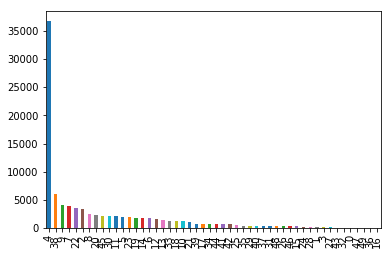

In [43]:
# analyze the clusters
top_clusters = test['Cluster'].value_counts()
top_clusters.plot.bar(x = 'Cluster', y = 'Counts')

In [44]:
# there is high volume for cluster 4, look at few to investigate
print(test[test.Cluster == 4].iloc[:10, [16,17,18,19]])

                                                                                      Short_description  \
2                                                                              PHX-VAPP-408 - SAC0 MGH0   
6   PHXASP03 RPG1216 Error message CPF4128 appeared during OPEN (C S D F). CASH_ADJS  CLPDAYEND  626...   
7                      WOW ||  Display on the Left Monitor is upside down ||  device id-  10.203.212.24   
9   PHXASP03 CPA0701 RPG9001 received by PHCL1956 at 2100. (C D I R) CASH_ADJS  CLPDAYEND  626868 QC...   
15                       'phx-app-040.chw.edu':There are '0 processes' processes called 'w3wp' Running'   
16                       'phx-app-034.chw.edu':There are '0 processes' processes called 'w3wp' Running'   
17                                                   MEDITECH ALERT (HIGH)                                
22  Phone - Not working || Ext - 4621 || Dept : ER Admitting / Loc : St Johns Regional Medical Cente...   
24  CIM_2_MCD95_HCLORDL:HCL99ORDL:HCC

In [45]:
# Add extra fields 
# test['Date'] = test['Created'].dt.date
# test['Hour'] = test['Created'].dt.hour
test['Date_hour'] = test['Created'].dt.strftime('%m/%d/%Y %H')
test['Weekday'] = test['Created'].dt.weekday

In [46]:
# test = test.drop(columns = ['Date', 'Hour'])

In [47]:
target_url_out = ("/Users/devkrroy/Dev/Projects/snow/data/export3_out.csv")
# target_url_out = ("C:/Dev/Projects/snow/data/export3_out.csv")
test.to_csv(target_url_out)

In [48]:
# exclude the incidents that can be random e.g. password resets/login issues. Following clusters to be excluded:

# 2  - account lock
# 4  - 
# 7  - cpu utilization
# 9  - password
# 20 - password
# 22 - account lock
# 38 - login
# 45 - utilization threshold

test_new = test[~test['Cluster'].isin([2, 4, 7, 9, 20, 22, 38, 45])]

In [49]:
target_url_out1 = ("/Users/devkrroy/Dev/Projects/snow/data/export3_out1.csv")
# target_url_out1 = ("C:/Dev/Projects/snow/data/export3_out1.csv")
test_new.to_csv(target_url_out1)

In [ ]:
lst = []
for item in test_new['Date_hour'].unique():
    # closure_ci_lst = list(test_new[test_new['Date_hour'] == item]['Closure_CI'].astype(str))
    # ci_lst = list(test_new[test_new['Date_hour'] == item]['Configuration_item'].astype(str))
    
    ips_lst = list(test_new[test_new['Date_hour'] == item]['IPs'].astype(str))

    ips_list = list(ip_cluster)   
    ips_str = ' '.join(ips_lst)
    ips_lst = ips_str.split()
    
    lst2 = ips_lst
    # lst2 = closure_ci_lst + ci_lst + ips_lst #+ cluster_lst
    
    # remove empty strings
    lst2 = list(filter(lambda x: x != '', lst2))
    
    # remove duplicates from list
    lst2 = list(dict.fromkeys(lst2))
    
    if len(lst2) > 0:
        lst.append(lst2)
    
print(lst[0:3])
print(len(lst))

In [93]:
# copy test dataframe to a new dataframe before performing association rules
# test_ar = (test[test['Country'] == "France"]
#            .groupby(['Date_hour', 'Description'])['Quantity']
#            .sum().unstack().reset_index().fillna(0)
#            .set_index('InvoiceNo'))


In [94]:
# resize list for quicker processing
lst_new = lst[:100]

In [95]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

te = TransactionEncoder()
te_data = te.fit(lst_new).transform(lst_new)

data_x = pd.DataFrame(te_data, columns = te.columns_)
print(data_x.head())

frequent_items = apriori(data_x, use_colnames = True, min_support = 0.05)
print(frequent_items.head())

   -10.169.60.11  -10.207.200.16  -10.207.205.29  -10.207.205.30  \
0          False           False           False           False   
1          False           False           False           False   
2          False           False           False           False   
3          False           False           False           False   
4          False           False           False           False   

   -10.207.205.31  -10.248.7.238  -10.248.84.17  -10.26.5.114  -10.36.69.166  \
0           False          False           True         False          False   
1           False          False          False         False          False   
2           False          False          False         False          False   
3           False          False          False         False          False   
4           False          False          False         False          False   

   -162.135.81.98          ...            wip3-161-main-msjmc  \
0           False          ...               

In [106]:
rules = association_rules(frequent_items, metric = "lift", min_threshold = 1)
rules.antecendents = rules.antecedents.apply(lambda x: next(iter(x)))
rules.consequents = rules.consequents.apply(lambda x: next(iter(x)))
rules.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(chw-cr1-1a-itc-r-sjpvh),10.1.103.4,0.08,0.08,0.08,1.0,12.5,0.0736,inf
1,(10.1.103.4),chw-cr1-1a-itc-r-sjpvh,0.08,0.08,0.08,1.0,12.5,0.0736,inf
2,(10.1.5.100),10.1.5.10,0.08,0.08,0.08,1.0,12.5,0.0736,inf
3,(10.1.5.10),10.1.5.100,0.08,0.08,0.08,1.0,12.5,0.0736,inf
4,(10.1.5.6),10.1.5.10,0.08,0.08,0.08,1.0,12.5,0.0736,inf


In [103]:
# The most significant rules
rules_imp = rules.sort_values('lift', ascending = 0)
rules_imp.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
27,(chw-wc1-mdf-main-sjpvh),10.139.251.5,0.06,0.06,0.06,1.0,16.666667,0.0564,inf
26,(10.139.251.5),chw-wc1-mdf-main-sjpvh,0.06,0.06,0.06,1.0,16.666667,0.0564,inf
40,(10.205.251.6),chw-wc2-mdf-main-mh,0.06,0.06,0.06,1.0,16.666667,0.0564,inf
41,(chw-wc2-mdf-main-mh),10.205.251.6,0.06,0.06,0.06,1.0,16.666667,0.0564,inf
42,(chw-as1-idf103-main-srdhs),10.250.238.50,0.06,0.06,0.06,1.0,16.666667,0.0564,inf
43,(10.250.238.50),chw-as1-idf103-main-srdhs,0.06,0.06,0.06,1.0,16.666667,0.0564,inf
0,(chw-cr1-1a-itc-r-sjpvh),10.1.103.4,0.08,0.08,0.08,1.0,12.500000,0.0736,inf
571,"(10.1.5.100, 10.1.5.6)",chw-as2-2central-dsc,0.08,0.08,0.08,1.0,12.500000,0.0736,inf
573,"(10.1.5.6, chw-as1-2central-dsc)",chw-as2-2central-dsc,0.08,0.08,0.08,1.0,12.500000,0.0736,inf
574,(chw-as2-2central-dsc),10.1.5.100,0.08,0.08,0.08,1.0,12.500000,0.0736,inf


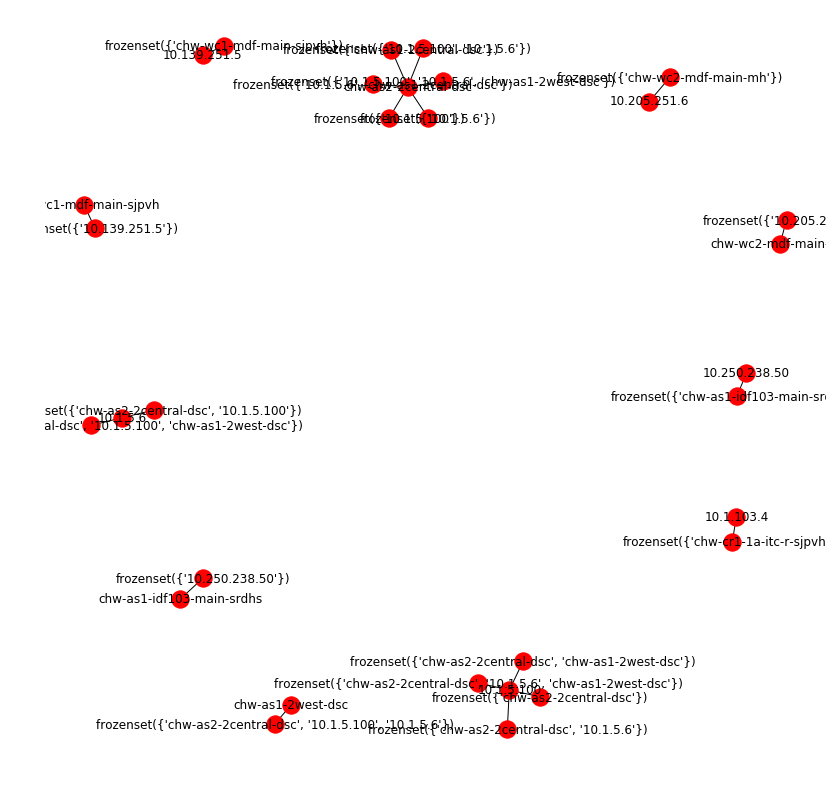

In [105]:
# network analysis
import networkx as nx
fig, ax = plt.subplots(figsize = (14, 14))
GA = nx.from_pandas_edgelist(rules_imp.head(20), source = 'antecedents', target = 'consequents')
nx.draw(GA, with_labels = True)
plt.show()